In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, auc, roc_curve
from pyod.models.auto_encoder import AutoEncoder
import optuna
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [2]:
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')

## Data Preprocessing for Training and Testing

In [3]:
df_train = df_train[df_train['class'] == 0]

In [4]:
X_train = df_train.drop('class', axis=1)
y_train = df_train['class']

X_test = df_test.drop('class', axis=1)
y_test = df_test['class']

In [5]:
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (67343, 30), Test shape: (22544, 30)


## Training the Model
- Manual hyperparameter tuning was performed due to the nature of the model and data.  
- Different hyperparameter values were tested, and the best ones were selected based on training loss, validation loss, accuracy, F1-score, and precision.  
- The following results correspond to the model trained with the best hyperparameters.  

In [6]:
model = AutoEncoder(epoch_num= 20, batch_size=128, hidden_neuron_list = [128,64])
model.fit(X_train)

Training: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


In [7]:
# save the model
with open('autoencoder_model.pkl', 'wb') as f:
    pickle.dump(model, f)

## Model Evaluation

In [6]:
# load model
with open('autoencoder_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [7]:
def plot_fast_fold(fold_data, fold_num, subsample_factor=10,subsample_factor_train =100):
    """Plot fold data with original styling but optimized rendering"""
    plt.figure(figsize=(12, 6))
    
    # Training data (always blue)
    train_scores = np.array(fold_data['train_scores'][::subsample_factor_train])
    train_pred = np.array(fold_data['train_pred'][::subsample_factor_train])
    
    # Split training into predicted normal/anomalous
    train_normal = train_pred == 0
    train_anomalies = train_pred == 1
    
    # Plot training normals (circles)
    plt.scatter(np.where(train_normal)[0], train_scores[train_normal],
                color='blue', marker='o', alpha=0.5, s=10, label='Train Normal')
    
    # Plot training anomalies (crosses)
    if np.any(train_anomalies):
        plt.scatter(np.where(train_anomalies)[0], train_scores[train_anomalies],
                    color='blue', marker='x', alpha=0.8, s=30, label='Train Anomalies')

    # Test data
    test_scores = np.array(fold_data['test_scores'][::subsample_factor])
    test_actual = np.array(fold_data['test_actual'][::subsample_factor])
    test_pred = np.array(fold_data['test_pred'][::subsample_factor])
    offset = len(train_scores)
    
    # Create test indices
    test_indices = np.arange(offset, offset + len(test_scores))
    
    # Split test data into 4 groups
    normal_normal = (test_actual == 0) & (test_pred == 0)
    normal_anomaly = (test_actual == 0) & (test_pred == 1)
    anomaly_anomaly = (test_actual == 1) & (test_pred == 1)
    anomaly_normal = (test_actual == 1) & (test_pred == 0)
    
    # Plot test normal-correct (green circles)
    plt.scatter(test_indices[normal_normal], test_scores[normal_normal],
                color='green', marker='o', alpha=0.5, s=10, label='Test Normal Correct')
    
    # Plot test normal-incorrect (green x)
    if np.any(normal_anomaly):
        plt.scatter(test_indices[normal_anomaly], test_scores[normal_anomaly],
                    color='green', marker='x', alpha=0.8, s=30, label='Test Normal Wrong')
    
    # Plot test anomaly-correct (red x)
    if np.any(anomaly_anomaly):
        plt.scatter(test_indices[anomaly_anomaly], test_scores[anomaly_anomaly],
                    color='red', marker='x', alpha=0.8, s=30, label='Test Anomaly Correct')
    
    # Plot test anomaly-incorrect (red circles)
    if np.any(anomaly_normal):
        plt.scatter(test_indices[anomaly_normal], test_scores[anomaly_normal],
                    color='red', marker='o', alpha=0.5, s=10, label='Test Anomaly Wrong')

    plt.title("Anomaly Scores (Actual vs Predicted)")
    plt.xlabel("Sample Index")
    plt.ylabel("Score")
    plt.grid(True)

    # Create simplified legend
    handles = [
        plt.Line2D([], [], color='blue', marker='o', linestyle='', label='Train Normal'),
        plt.Line2D([], [], color='blue', marker='x', linestyle='', label='Train Anomaly'),
        plt.Line2D([], [], color='green', marker='o', linestyle='', label='Normal'),
        plt.Line2D([], [], color='green', marker='x', linestyle='', label='Normal Pred Wrong'),
        plt.Line2D([], [], color='red', marker='x', linestyle='', label='Anomaly'),
        plt.Line2D([], [], color='red', marker='o', linestyle='', label='Anomaly Pred Wrong')
    ]
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
def plot_fast_histograms(hist_data):
    """Histogram plot with original color scheme"""
    plt.figure(figsize=(10, 6))
    
    sns.histplot(hist_data['train_scores'], color='blue', 
                 label='Train (Normal)', kde=True, element='step')
    sns.histplot([s for s, l in zip(hist_data['test_scores'], hist_data['test_labels']) if l == 0],
                 color='green', label='Test Normal', kde=True, element='step')
    sns.histplot([s for s, l in zip(hist_data['test_scores'], hist_data['test_labels']) if l == 1],
                 color='red', label='Test Anomalous', kde=True, element='step')
    
    plt.title('Aggregated Anomaly Score Distributions (Original Style)')
    plt.legend()
    plt.show()

In [8]:
train_scores = model.decision_function(X_train)
test_scores = model.decision_function(X_test)  

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

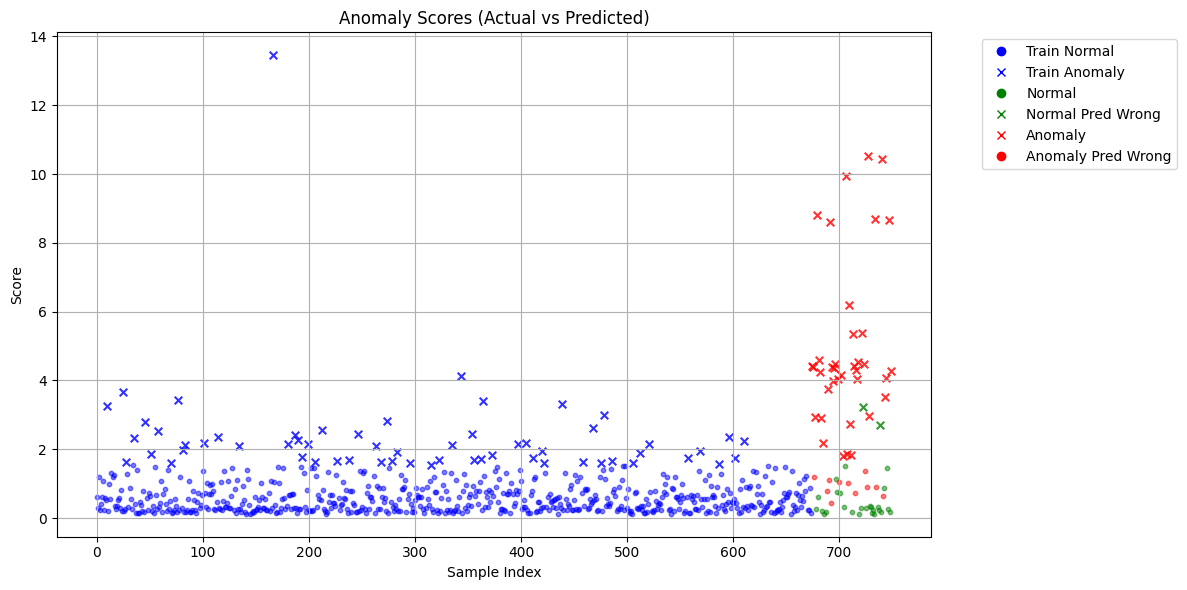

In [ ]:
fold_data = {
    'train_scores': train_scores.tolist(),
    'train_pred': y_pred_train,
    'test_scores': test_scores.tolist(),
    'test_actual': y_test.tolist(),
    'test_pred': y_pred
}

plot_fast_fold(fold_data, fold_num=0, subsample_factor=300, subsample_factor_train=100)

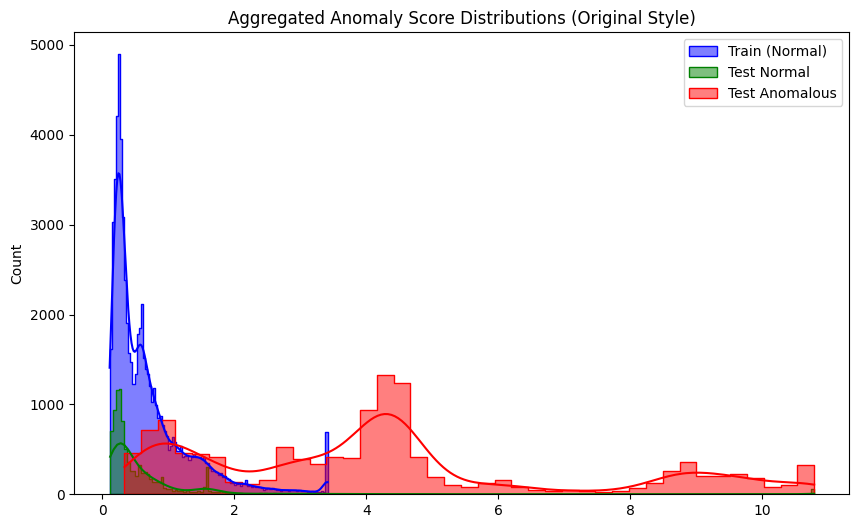

In [ ]:
def clip_outliers(scores, max_val=None):
    scores = np.asarray(scores).flatten()
    if max_val is None:
        max_val = np.percentile(scores, 99)  # clip top 1%
    return np.clip(scores, None, max_val)

# cliiping due to the range of score values is very large
histogram_data = {
    'train_scores': clip_outliers(train_scores),
    'test_scores': clip_outliers(test_scores),
    'test_labels': y_test
}
plot_fast_histograms(histogram_data)

In [13]:
# Classification reports
print("Test Classification Report:")
print(classification_report(y_test, y_pred))

y_test_train = np.zeros(len(X_train))
print("\nTrain Classification Report:")
print(classification_report(y_test_train, y_pred_train))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.91      0.82      9711
           1       0.92      0.78      0.84     12833

    accuracy                           0.83     22544
   macro avg       0.84      0.84      0.83     22544
weighted avg       0.85      0.83      0.84     22544


Train Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95     67343
         1.0       0.00      0.00      0.00         0

    accuracy                           0.90     67343
   macro avg       0.50      0.45      0.47     67343
weighted avg       1.00      0.90      0.95     67343



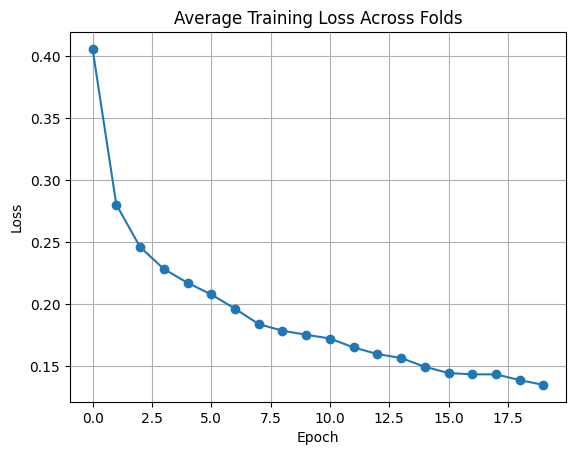

In [17]:
training_losses = model.training_losses
plt.plot(training_losses, marker='o')
plt.title("Average Training Loss Across Folds")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()